## Test compare the chemistry.py

In [1]:
import numpy as np
import pyc2ray as p2c
import matplotlib.pyplot as plt

import astropy.units as u
import astropy.constants as cst
from astropy.cosmology import Planck18 as cosmo

2024-05-27 19:15:53.295217: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-27 19:15:53.321226: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-27 19:15:53.321249: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-27 19:15:53.321936: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-27 19:15:53.326477: I tensorflow/core/platform/cpu_feature_guar

### Define fields
in this example we define some random density fields for the gas density <b>ndens</b>, temperature <b>temp</b>, ionization fraction <b>xh</b> and photo-ionization rate <b>phi_ion</b>.</br>
These four field can be a single value or a numpy array with the same shape.

In [2]:
#mesh_shape = (10,10,10)
mesh_shape = (1,1,1)

np.random.seed(2023)
# density field [g/cm^3]
ndens = np.ones(mesh_shape)*1e-6

# temperature [K]
temp = np.ones(mesh_shape)*1e4

# clumping factor
clumping = np.ones(mesh_shape)

# Hydrogen ionization fraction
xh = np.ones(mesh_shape)*0.1 #np.random.uniform(low=0, high=0.1, size=mesh_shape)
xh_ini = xh.copy()
print(xh_ini)
# photo-ionization rate [s^-1]
phi_ion = np.random.uniform(low=1e-13, high=1e-12, size=mesh_shape)

[[[0.1]]]


### Define the time-step loop

In [3]:
# time-step
dt = 50*u.yr
t_steps = 10000

print('Volume-averaged ionized fraction at t=0: %.3f' %np.mean(xh_ini))

# calculate ODE
t_arr = np.arange(t_steps)*dt.value
xh_arr = np.zeros(t_steps)
for i in range(t_steps):
    new_xh = p2c.solver.hydrogenODE(dt=dt.cgs.value, ndens=ndens, temp=temp, xh=xh, phi_ion=phi_ion, clump=clumping)
    xh = new_xh
    xh_arr[i] = xh

print('Volume-averaged ionized fraction after t=%d %s: %.3f' %(dt.value*t_steps, dt.unit, np.mean(xh)))

Volume-averaged ionized fraction at t=0: 0.100
Volume-averaged ionized fraction after t=500000 yr: 0.998


In [4]:
# time-step
dt = 50*u.yr
t_steps = 10000

bh00=2.59e-13
albpow=-0.7
colh0=1.3e-8
abu_c=7.1e-7
temph0 = (13.598*u.eV/cst.k_B).cgs.value

print('Volume-averaged ionized fraction at t=0: %.3f' %np.mean(xh_ini))

# calculate ODE
t_arr = np.arange(t_steps)*dt.value
xh_arr = np.zeros(t_steps)
for i in range(t_steps):
    new_xh = p2c.chemistry.global_pass(dt.cgs.value, ndens, temp, xh, xh, xh, phi_ion, clumping, bh00, albpow, colh0, temph0, abu_c)
    xh = new_xh
    xh_arr[i] = xh

print('Volume-averaged ionized fraction after t=%d %s: %.3f' %(dt.value*t_steps, dt.unit, np.mean(xh)))

Volume-averaged ionized fraction at t=0: 0.100


TypeError: unsupported operand type(s) for -: 'NoneType' and 'float'

### Plot the results

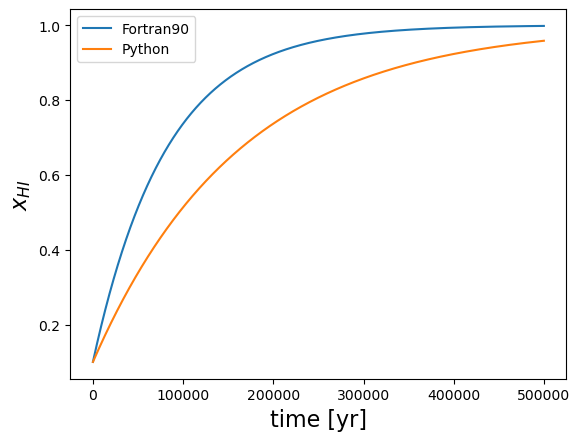

In [25]:
plt.plot(t_arr, xh_arr, label='Fortran90')
plt.plot(t_arr, xh_arr2, label='Python')
plt.xlabel('time [yr]', size=16), plt.ylabel(r'$x_{HI}$', size=16)
plt.legend()

In [21]:
xh = np.ones(mesh_shape)*0.1 #np.random.uniform(low=0, high=0.1, size=mesh_shape)
xh_old = xh
abu_c=7.1e-7


# temperature [K]
temp = np.ones(mesh_shape)*1e4

# clumping factor
clumping = np.ones(mesh_shape)

xh_arr2 = np.zeros(t_steps)
bh00=2.59e-13
albpow=-0.7
colh0=1.3e-8
abu_c=7.1e-7
temph0 = (13.598*u.eV/cst.k_B).cgs.value

epsilon = 1e-14

#xh_intermed = xh_ini
for i in range(t_steps):
    #xh_intermed = xh
    #conv_flag = p2c.chemistry.global_pass(dt.cgs.value, ndens, temp, xh, xh, xh_intermed, phi_ion, clumping, bh00, albpow, colh0, temph0, abu_c, xh.shape[0], xh.shape[1], xh.shape[2])
    #xh_arr2[i] = xh_intermed
    
    # collisional ionizaiton 
    rhe = ndens * (xh + abu_c)

    acolh0 = colh0 * np.sqrt(temp) * np.exp(-temph0 / temp)
    aih0 = phi_ion + rhe * acolh0

    # Recombination rate
    brech0 = clumping * bh00 * (temp / 1e4)**albpow
    delth = aih0 + rhe * brech0

    # equilibrium solution
    eqxh = aih0 / delth

    # time scale, t_i
    deltht = delth * dt.cgs.value

    # analytical solution
    xh = eqxh + (xh_old - eqxh) * np.exp(-deltht)
    if xh < epsilon:
        xh = epsilon

    # time-averaged ionization fraction
    if deltht < 1.0e-8:
        xh_av = eqxh + (xh_old - eqxh)
    else:
        xh_av = eqxh + (xh_old - eqxh) * (1.0 - np.exp(-deltht)) / deltht

    if xh_av < epsilon:
        xh_av = epsilon

    # update previous timestep
    xh_arr2[i] = xh_av
    xh_old = xh_av